This project aims to predict an individual's nationality based on information from her/his Wikipedia biography, i.e., text analysis based multiclass prediction/classification. 

This project consists of the following key stages:
1. [<b>Text Processing:</b>](#text_processing) Approximately 319K individual biographies were analyzed which cover more than 20 distinct nationalities. spacy, nltk, regex and sklearn libraries were used to process the text based data prior to modeling.
   * [Part 1 - Cleaning the Target (Nationality) Field](#target_clean)
   * [Part 2 - Cleaning the Biography Field](#target_clean)

#####
2. [<b>Prediction Modeling:</b>](#prediction_modeling) A logistic regression based model was used to predict the nationalities frome the text based biography inputs. Note: the focus of this project is more on gaining experience with text processing rather that classification modeling (which I have covered in other projects), so only logisitc regression is used in this project. Some potential other models that could be explored include Multinomial Naive Baiyes or Random Forest Classification, for instance.
   * [Part 1 - Classification Model on the Unbalanced Dataset](#unbal_models)
   * [Part 2 - Balancing the Dataset](#bal_models)

##### Data Loading and Initial Processing
We load the necessary libraries and the relevant dataset scrapped from Wikipedia (via University of Michigan). The raw dataset consists of ~319K records consisting of a text based 'biography' feature and a multiclass 'nationality' field. Both fields contain noise; in particular, nationalities may be represented in various form, e.g., "american" vs "united states, american" vs "u.s". Further details and relevent data cleaning/text processing steps are described in the next section

In [18]:
##generic libraries
import warnings
warnings.filterwarnings("ignore")
import time
import numpy as np
import pandas as pd
RANDOM_SEED = 655


##text processing specific
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import regex as re
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
# !pip install spacy
# !python -m spacy download en_core_web_sm
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()


##text visualizations
import matplotlib.pyplot as plt
# !pip install wordcloud
from wordcloud import WordCloud


##classification modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay


##dealing with unbalanced data
# !pip install imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [33]:
df_raw = pd.read_csv('data/raw/bio_nationality.tsv.gz', sep='\t', compression='gzip', index_col=0)
df_raw.dropna(inplace = True)  #### skip entries with missing values (drop 11)

print(f"The dataset has {df_raw.shape[0]} records\n")
print("Table 1 - Percentages of the top 5 nationalities in the original dataset:")
round(df_raw.nationality.value_counts().head()/df_raw.shape[0]*100,2)

The dataset has 319358 records

Table 1 - Percentages of the top 5 nationalities in the original dataset:


nationality
american                   13.51
british                     5.21
indian                      3.37
united states, american     3.07
australian                  2.59
Name: count, dtype: float64

In [8]:
print("Sample Bio:")
df_raw.bio.sample().values[0]

Sample Bio:


'Early life\nGift was born on 28 May 1961 in Sparkhill in the city of Birmingham, in England\'s West Midlands, to an English mother and an Afro-Caribbean father. He lived in Sparkhill until the age of 11, receiving his early formal education at Anderton Park School and Arden Primary School. His family then moved to Kingston upon Hull, where his mother, Pauline, ran several second-hand clothes shops, whilst he was a pupil at Kelvin Hall School.\nMusic career\nGift\'s first recording, on which he played the saxophone, was with Hull ska band Akrylykz; the second release on York\'s Red Rhino Records. Although this record was unsuccessful, it did bring him to the attention of Andy Cox and David Steele of the Beat. Akrylykz toured with the Beat, which led to them, in around 1985, asking him to be the lead singer of their new band Fine Young Cannibals after their old band, the Beat, had broken up. He also was a guest artist on the Ska City Rockers\' "Time Is Tight" single.\n\nIn 1990, he was 

In [39]:
print("Sample Nationalities:")
list(df_raw.nationality.sample(3).values)

Sample Nationalities:


['france, french', 'romanian', 'united kingdom, scottish']

#####
#### Text Processing <a class="anchor" id="text_processing"></a>
One challenge in with most text based datasets is that the text inputs maybe noisy. Consider the target field ("nationality") shown above. Exploratory observations show that there can be some inconsistency in the way nationalities are represented, e.g., "american" vs "united states, american". Further, some nationality data is garbled or lists more than one nationality, e.g., "norway, norwegian and germany, german" or "rus) (pol"

The first task therefore, is to clean the target field. Three approaches are explored to clean the nationality field:
1. manual transformations based of some of the main type of observed issues
2. using spacy named entity recognition directly
3. using a combination of approaches 1 and 2
#####
#### Part 1: Cleaning the target field<a class="anchor" id="target_clean"></a>
<b>Approach 1 - Prior Knowledge Based Transformations:</b>
This approach utilizes prior knowledge about common types of issues identified in the target field during exploratory data analsysis (such as those explained above). Manual transformations designed based on this prior knowledge are then applied to clean the target field. This approach works pretty well and is able to improve the class groupings in the nationality target field. It is unable to clean only about 1% of the records in the target field.

In [44]:
def nationality_cleanup_basic(x, basic = True):
    """This function manually cleans the nationality field based on known most common types of errors seen in the data. 
    This is a brute force approach and any nuances in the nationality field are lost"""
    
    nationalities = x.split(",")
    if len(nationalities) == 1:
        _ = nationalities[0].strip()
    elif len(nationalities) == 2:
        _ = nationalities[1].strip() ## we know that typically the nationality appears immediately after the comma
    else: 
        _ = None
        
    if _ in ["us", "united states", "usa", "U.S.A."]:
        _ = "american"
    elif _ in ["united kingdom", "uk", "english", "eng"]:
        _ = "british"

    if basic == False and _ == None:
        return x
    else:    return _

# df = df_raw.copy()
# df["nationality_manual_clean"] = df.nationality.apply(lambda x: nationality_cleanup_basic(x, basic = True))

# df = pd.read_pickle("data/raw/nationality_df.pkl")
# print(f"This approach was unable to identify nationality for {round(df.nationality_manual_clean.isna().sum()/df.shape[0]*100,2)}% of the records")
df[["bio", "nationality", "nationality_manual_clean"]].sample(3)

,bio,nationality,nationality_manual_clean
8647,Background and education\nPortland was the eld...,british,british
238155,Journalism career\nMugisha built her name as a...,ugandan,ugandan
56472,Early life\nHirsch was born in Cologne in the ...,"germany, german australian.",german australian.


In [36]:
print("Table 2 - Percentages of the top 5 nationalities after manual cleaning:")
round(df.nationality_manual_clean.value_counts().head()/ df.shape[0]*100, 2)

Table 2 - Percentages of the top 5 nationalities after manual cleaning:


nationality_manual_clean
american    21.11
british      9.23
indian       4.01
french       3.04
german       2.75
Name: count, dtype: float64

<b>Observations:</b> Note that the discrepancy in how "american" is represented in the nationality target field is removed which improves the groupings (Table 1 vs Table 2). 

While this approach works quite well to clean the nationality groupings, one critical drawback is that it requires that we know what are some of the common types of errors in the nationality field ahead of time. This type of prior knowledge is not always possible to obtain, e.g., we may not have access to the data for exploratory analysis. Therefore, the second approach, more automated approach is explored that extracts nationalities directly using spacy is explored.

####
<b>Approach 2 - Spacy Named Entity Recognition Based Transformations:</b>
This approach uses spacy's 'Named Entity Recognition' functionality to automate the nationality cleaning/extraction process. Unlike Approach 1, in this approach, no prior knowlegdge of the common types of noise seen needs to be provided to aid in the cleaning task. This approach also works quite well and is only unsuccessful at cleaning about 3% of the target field.

In [21]:
def nationality_cleanup_spacy(x):
    """This function extracts nationality information using spacy named entity recognition:
       * NORP ("Nationalities or religious or political groups") and GPE ("Geo-Political Entity")
       Note that in cases where more than one nationality is extracted, only the first nationality is returned"""
    
    doc = nlp(x)
    if len(doc) == 1: ##if we only have one nationality specified, we used it directly
        return list({word.lemma_ for word in doc})[0]
        # return {sbs.stem(x)}
        
    else: ##if we have additional information, we try to extract the nationality using spacy NORP 
        # https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da
        
        NORP_GPE_extract = [(X.text, X.label_) for X in doc.ents]
        nationalities = list({lemmatizer.lemmatize(X[0]) for X in NORP_GPE_extract if X[1] == "NORP"})
        countries = list({lemmatizer.lemmatize(X[0]) for X in NORP_GPE_extract if X[1] == "GPE"})
        # nationalities = {sbs.stem(X[0] for X in NORP_GPE_extract if X[1] == "NORP"}
        # countries = {sbs.stem(X[0]) for X in NORP_GPE_extract if X[1] == "GPE"}
        
        if len(nationalities) >= 1:
            return nationalities[0]
        elif len(countries) >= 1: ##if no nationality information could be effectively extracted, we try to extract country names
            return countries[0]
        else: return None

# df["nationality_spacy_clean"] = df.nationality.apply(lambda x: nationality_cleanup_spacy(x))
# print(f"spacy based cleanup takes ~{round((time.time() - start)/60,2)}m to run") # ~24.82m to run

# print(f"this approach was unable to identify nationality for {round(df_raw.nationality_spacy_clean.isna().sum()/df_raw.shape[0]*100,2)}% records")
df[["bio", "nationality", "nationality_spacy_clean"]].sample(3)

,bio,nationality,nationality_spacy_clean
69842,Hermann Adolf Alexander Schmidt (– ) was a Bal...,baltic german,german
291059,Swimming career\nBrown was a two times British...,eng,eng
171628,International career\nZuniga placed 4th at the...,american,american


In [23]:
print("Table 3 - Percentages of the top 5 nationalities after spacy based NORP/GPE extraction:")
round(df.nationality_spacy_clean.value_counts().head()/ df.shape[0]*100, 2)

Table 3 - Percentages of the top 5 nationalities after spacy based NORP/GPE extraction:


nationality_spacy_clean
american      18.89
british        7.24
indian         4.15
french         3.28
australian     3.14
Name: count, dtype: float64

<b>Observation:</b> Spacy fails to correctly clean the nationality target field for about 3% of the records (compared to 1% via direct transformations) and the results obtain from spacy based nationality extraction also contain some noise (e.g., american and united states are separate entities). But in general, the results are comparable especially when we consider that spacy did not require any prior information on the types of noise observed in the nationality column, and was able to extract the relevant nationalities independently. 

####
<b>Approach 3 - Combined:</b> Both techniques are combined in a final third approach where we manually correct any obvious/known issues (such as those discussed in in the introduction) and then apply spacy. This combined approach is an improvement on the spacy NER only approach (approach 2) and the percentage of records it fails to clean drops from 3% to about 2% of the records.

In [38]:
# df["nationality_manual_clean_wo_null"] = df.nationality.apply(lambda x: nationality_cleanup_basic(x, basic = False))
# df.nationality_manual_clean_wo_null.isna().sum()
# df["nationality_manual_spacy_clean"] = df.nationality_basic2.apply(lambda x: nationality_cleanup_spacy(x))
# print(f"spacy based cleanup takes ~{round((time.time() - start)/60,2)}m to run") #~55.51m to run
# df.to_pickle("data/raw/nationality_df.pkl")

# print(f"this approach was unable to identify nationality for {round(df_raw.nationality_manual_spacy_clean.isna().sum()/df_raw.shape[0]*100,2)}% records")
df[["bio", "nationality", "nationality_manual_spacy_clean"]].sample(3)

,bio,nationality,nationality_manual_spacy_clean
190475,"Early life\nDonald Fraser was born in Toronto,...","canadians, canadian",canadian
318995,Parliamentary career\n===National Council of P...,south african,south african
159567,Early life and education\nSansom grew up in Ea...,british,british


####
#### Part 2: Cleaning the biography field<a class="anchor" id="bio_clean"></a>
<b> Dataset Reduction:</b>
Text processing is a computing resource intensive task (and I have limited compute resources for personal use:). Therefore, prior to cleaning the biography feature, the dataset is reduced to a more manageable size. 

The cleaned dataset still has 2190 nationalities. Prior to further text processing on the biography field, the dataset is narrowed down to nationalities that have atleast 1% presentation in the dataset, which results in 17 unique nationalities.

In [46]:
df_clean = df[["bio", "nationality_manual_spacy_clean"]]
df_clean.columns = ["bio", "nationality_clean"]

nationalities_freq = round(df_clean.nationality_clean.value_counts()/df_clean.shape[0]*100, 2)
print(f"The cleaned dataset still has {nationalities_freq.shape[0]} nationalities")

##narrowing it down to nationalities that have atleast 1% presentation in the dataset
nationalities_freq_keep = nationalities_freq[nationalities_freq>1]
nationalities_freq_keep

The cleaned dataset still has 2190 nationalities


nationality_clean
american      21.62
british        9.53
indian         4.14
french         3.27
australian     3.11
german         2.97
canadian       2.93
italian        2.46
japanese       2.00
spanish        1.39
irish          1.30
russian        1.30
mexican        1.25
polish         1.20
dutch          1.15
norwegian      1.12
pakistani      1.11
Name: count, dtype: float64

In [2]:
df_reduced = df_clean[df_clean.nationality_clean.apply(lambda x: x in nationalities_freq_keep.index)]
print(f"The reduced dataset has {nationalities_freq_keep.shape[0]} nationalities")
print(f"The original dataset had {df_clean.shape[0]} records and the reduced dataset (with only the above reduced nationalities), has {df_reduced.shape[0]} records.")
# df_reduced.to_pickle("data/raw/nationality_df_reduced.pkl")

####
<b>Biography Text processing:</b>
Typical text based processing consisting of removing stopwords, alpahnumerics and other noise, as well as tokenization and lemmatization is applied to the biographies in the dataset.

In [39]:
# start_time = time.time()
"""steps:
- regex to remove any punctuations or alphanumeric words
- remove stopwords and tokenizes the remaining text
- lemmatization (spacy lemmatization takes pos_tags into account directly
"""

def remove_non_words(x):
    return re.sub(r"[^A-Za-z\ +]", "", x)

def tokenize(x):
    return " ".join([word for word in nltk.word_tokenize(x) if word.lower() not in stop_words])
    
def spacy_lemma(x):
    doc = nlp(x)
    return [word.lemma_ for word in doc] #need list for word cloud

# df_final = df_reduced.copy()
# df_final["bio_clean"] = df_final.bio.apply(lambda x: spacy_lemma(tokenize(remove_non_words(x))))
# end_time = time.time()
# print(round((end_time-start_time)/60,2))  #77.67m
# df_final[["bio_clean", "nationality_clean"]].to_pickle("data/final_df.pkl")

df_final = pd.read_pickle("data/final_df.pkl")
df_final.head(3)

,bio_clean,nationality_clean
0,"[Alain, Connes, bear, April, French, mathemati...",french
1,"[life, early, life, Schopenhauers, birthplace,...",german
3,"[early, lifealfre, Vogt, Elton, van, add, much...",canadian


##### Analyzing Biographies via WordClouds <a class="anchor" id="word_cloud"></a>

In [31]:
##word cloud for the overall text corpus of bios
## https://www.datacamp.com/tutorial/wordcloud-python
def create_word_cloud(df_final, title):
    """creates a word cloud based on the text corpus provided"""
    _ = []
    df_final.bio_clean.apply(lambda x: _.extend(x))
    text_corpus = " ".join(_)
    word_cloud = WordCloud(max_font_size=50, background_color="white").generate(text_corpus)
    plt.title(title + " Word Cloud")
    plt.imshow(word_cloud);
    plt.axis('off');

    return plt

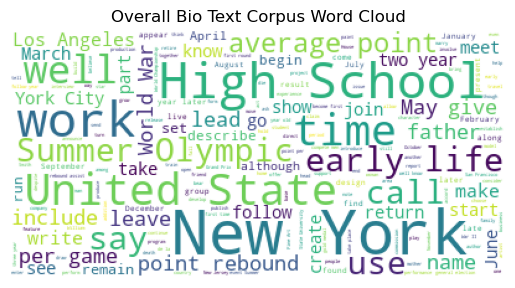

In [4]:
plt = create_word_cloud(df_final, "All Bios")
plt.savefig("figures/overall_wc.png", bbox_inches='tight');        

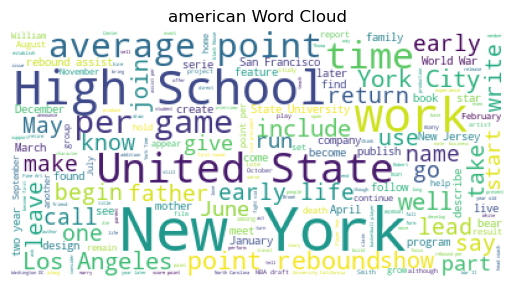

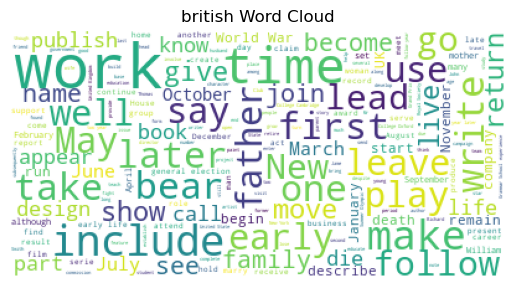

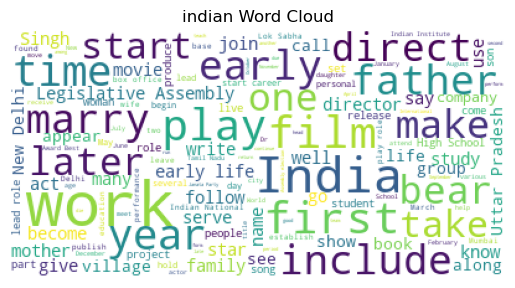

<Figure size 640x480 with 0 Axes>

In [8]:
##word clouds for the top three nationalities
for nat in df_final.nationality_clean.value_counts().index[:3]:
    df_temp = df_final[df_final.nationality_clean == nat]
    plt = create_word_cloud(df_temp, nat);
    plt.show();
    plt.savefig("figures/" + str(nat)+ "_wc.png", bbox_inches='tight');

####
#### Prediction Modeling<a class="anchor" id="prediction_modeling"></a>
##### Splitting into training and test sets. Validation set is not used for this simple project

In [41]:
# df_final.bio_clean = df_final.bio_clean.apply(lambda x: " ".join(x)) #need strings for vectorizer
# # df_final.head()

X_train, X_test, y_train, y_test =  train_test_split(df_final.bio_clean, df_final.nationality_clean, stratify = df_final.nationality_clean)
# print(X_train.shape) #(148153,)
# print(X_test.shape) #(49385,)

(148153,)
(49385,)


#### Part 2: Classification Model on Unbalanced Dataset <a class="anchor" id="unbal_models"></a>

##### Vectorization
Tfidf vectorizer is preferred over CountVectorizer as we want to give preference to unique words within a bio

In [42]:
tf = TfidfVectorizer(min_df = .01, max_df = .95)
X_train_tf = tf.fit_transform(X_train) ##spare array of shape (148153, 1769)
X_test_tf = tf.transform(X_test)

In [12]:
print(f"The tfidf vectorizer identidified {len(tf.get_feature_names_out())} features")
tf.get_feature_names_out()[:10]

The tfidf vectorizer identidified 1775 features


array(['abandon', 'ability', 'able', 'abroad', 'academic', 'academy',
       'accept', 'accident', 'acclaim', 'accompany'], dtype=object)

##### Logistic Regression

In [46]:
lr = LogisticRegression().fit(X_train_tf, y_train)
nationality_predictions = lr.predict(X_test_tf)
# nationality_predictions.shape

lr_f1_macro = f1_score(y_test, nationality_predictions,  average = "macro") 
lr_f1_micro = f1_score(y_test, nationality_predictions,  average = "micro") 
print(f"The logistic regression model has a macro f1 score of {round(lr_f1_macro, 4)} and a micro f1 score of {round(lr_f1_micro, 4)}")
##macro since we want to take into account performance on the minority classes
## https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

The logistic regression model has a macro f1 score of 0.8757 and a micro f1 score of 0.8882


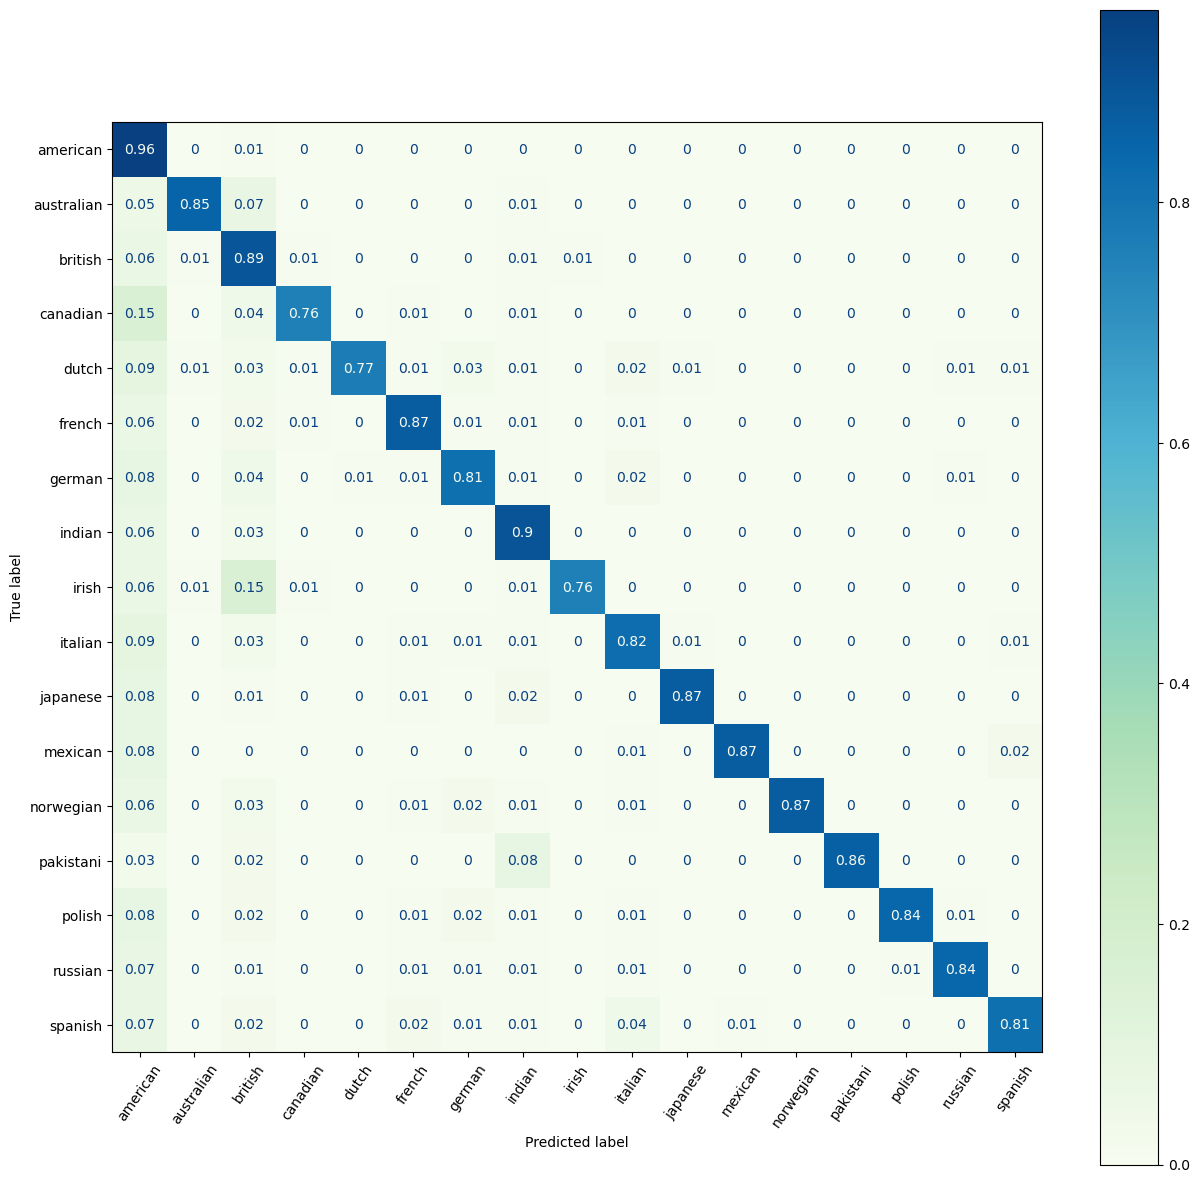

In [13]:
lr_confm = confusion_matrix(y_test, nationality_predictions, normalize = 'true').round(2)
confm_plt = ConfusionMatrixDisplay(lr_confm, display_labels = lr.classes_)
fig, ax = plt.subplots(figsize=(15,15))
confm_plt.plot(ax=ax, cmap=plt.cm.GnBu)
ax.tick_params(axis='x', rotation=55)
plt.savefig("figures/LogReg_ConfMatrix.png")

#### Part 3: Classification Model on Balanced Dataset <a class="anchor" id="bal_models"></a>
<b>Dataset Imbalance:</b> The proportion of nationalities in our final dataset is not balanced as shown below. This may cause results to be skewed towards the more dominant class.

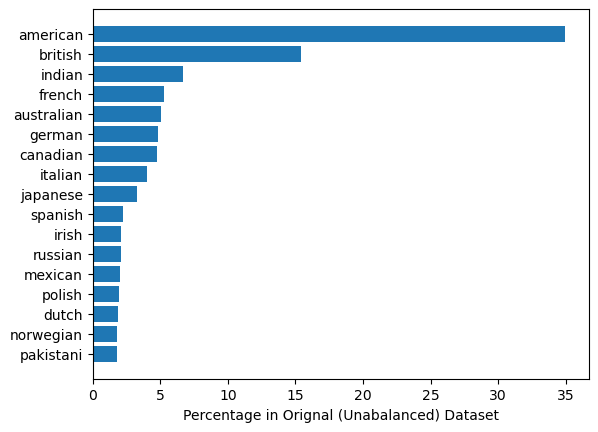

In [66]:
## https://machinelearningmastery.com/multi-class-imbalanced-classification/
_ = round(y_train.value_counts()/y_train.shape[0]*100,2)
_
plt.barh(_.sort_values().index, _.sort_values());
plt.xlabel("Percentage in Orignal (Unabalanced) Dataset");

As previously discussed, the cleaned/ reduced dataset is unbalanced which may skew the predictive model's results in favor of the dominant class. To balance the dataset we first randomly undersample the two dominant classes and then use SMOTE to oversample the minority classes


In [48]:
y_train.value_counts()

nationality_clean
american      51783
british       22824
indian         9912
french         7838
australian     7456
german         7108
canadian       7019
italian        5890
japanese       4795
spanish        3326
irish          3113
russian        3110
mexican        3004
polish         2864
dutch          2756
norwegian      2692
pakistani      2663
Name: count, dtype: int64

In [57]:
##https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
## https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTE.html

usamp_strategy = {'american': 22000, 'british': 22000}
X_train_tf_usamp, y_train_usamp = RandomUnderSampler(sampling_strategy = usamp_strategy).fit_resample(X_train_tf, y_train) #Undersampling is applied on the vectorized data

smote_strategy = dict(zip(y_train.unique(), [30000]*y_train.nunique()))
X_train_tf_bal, y_train_bal = SMOTE(sampling_strategy = smote_strategy).fit_resample(X_train_tf_usamp,y_train_usamp) 
y_train_bal.value_counts()

nationality_clean
american      30000
australian    30000
british       30000
canadian      30000
dutch         30000
french        30000
german        30000
indian        30000
irish         30000
italian       30000
japanese      30000
mexican       30000
norwegian     30000
pakistani     30000
polish        30000
russian       30000
spanish       30000
Name: count, dtype: int64

In [61]:
# _ = round(y_train_bal.value_counts()/y_train.shape[0]*100,2)
# _

# plt.barh(_.sort_values().index, _.sort_values());
# plt.xlabel("Percentage in Balanced Dataset");

In [59]:
lr_bal = LogisticRegression().fit(X_train_tf_bal, y_train_bal)
nationality_predictions_bal = lr_bal.predict(X_test_tf)
# nationality_predictions.shape

lr_bal_f1_macro = f1_score(y_test, nationality_predictions_bal,  average = "macro") 
lr_bal_f1_micro = f1_score(y_test, nationality_predictions_bal,  average = "micro") 

print(f"The logistic regression model has a macro f1 score of {round(lr_bal_f1_macro, 4)} and a micro f1 score of {round(lr_bal_f1_micro, 4)}")
##macro since we want to take into account performance on the minority classes
## https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

The logistic regression model has a macro f1 score of 0.8489 and a micro f1 score of 0.8712


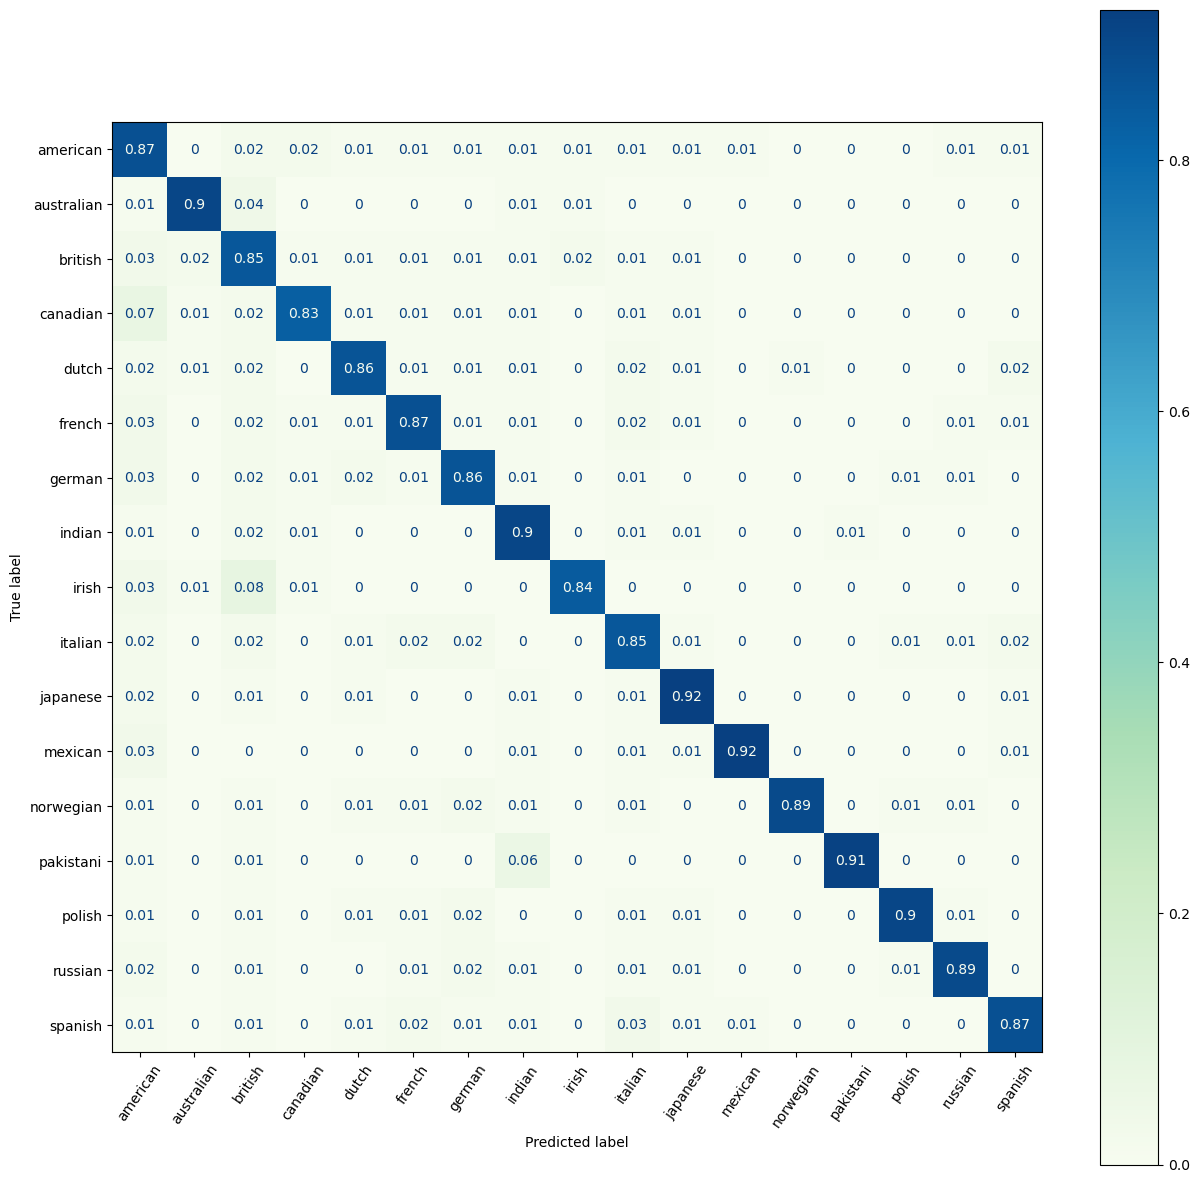

In [60]:
lr_bal_confm = confusion_matrix(y_test, nationality_predictions_bal, normalize = 'true').round(2)
confm_plt = ConfusionMatrixDisplay(lr_bal_confm, display_labels = lr_bal.classes_)
fig, ax = plt.subplots(figsize=(15,15))
confm_plt.plot(ax=ax, cmap=plt.cm.GnBu)
ax.tick_params(axis='x', rotation=55)
plt.savefig("figures/LogReg_Bal_ConfMatrix.png")

Balancing the dataset results in better results in under represented classes